# Implementation of chosen parts of H.261 and MPEG-1 algorithms

#### Flow Diagram for H.261 Encoding

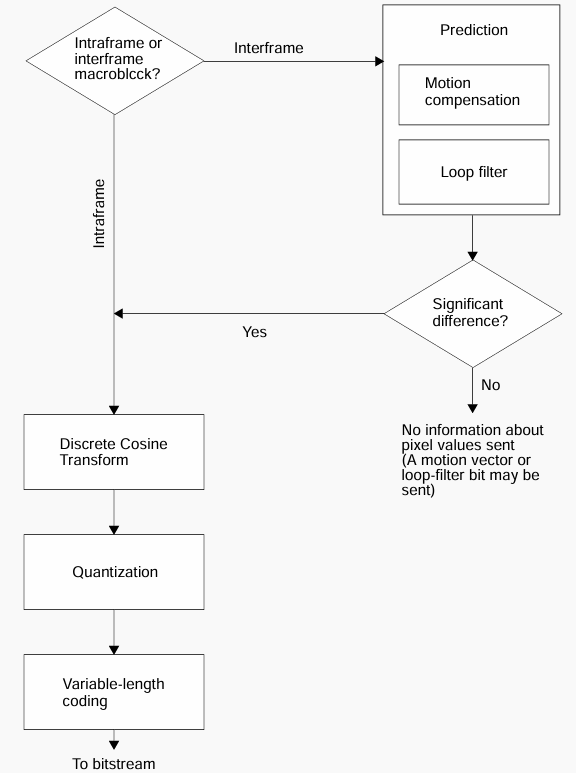

*source: https://www.ics.agh.edu.pl/dydaktyka/mm/lato0405_inf_d/laboratoria/Kompresja/Kodeki/h261.pdf*

DCT, iDCT, quantization, inverse quantization, entropy coding are presented in this Notebook.

In [52]:
#@title Required imports

import numpy as np
from scipy.fftpack import dct, idct
import heapq
from collections import defaultdict, Counter

## Discrete Cosine Transform (DCT)

The Discrete Cosine Transform (DCT) is a critical component of many video compression algorithms, including H.261 and MPEG-1. Both of these standards use a variant of the DCT called the 8x8 DCT, which operates on 8x8 blocks of pixels.

### Normalization Factor

\begin{equation}
\alpha(u) = \begin{cases}
\frac{1}{\sqrt{2}} & \text{if } u = 0 \\
1 & \text{otherwise}
\end{cases}
\end{equation}

In [2]:
#@title Normalization Factor implementation

def alpha(u):
    """ calculates the normalization factor α(u) """
    return 1/np.sqrt(2) if u == 0 else 1

### Discrete Cosine Transform (DCT) Formula
\begin{equation}
C(u, v) = \frac{1}{4} \alpha(u) \alpha(v) \sum_{x=0}^{7} \sum_{y=0}^{7} f(x, y) \cos\left(\frac{(2x+1)u\pi}{16}\right) \cos\left(\frac{(2y+1)v\pi}{16}\right)
\end{equation}

In [3]:
#@title DCT implementation

def dct_2d(block):
    """ Perform 2D DCT (Discrete Cosine Transform) on an 8x8 block """
    N = 8
    result = np.zeros((N, N))
    for u in range(N):
        for v in range(N):
            sum = 0
            for x in range(N):
                for y in range(N):
                    sum += block[x, y] * np.cos((2*x+1) * u * np.pi / (2*N)) * np.cos((2*y+1) * v * np.pi / (2*N))
            result[u, v] = 0.25 * alpha(u) * alpha(v) * sum
    return result

### Inverse Discrete Cosine Transform (IDCT) Formula
\begin{equation}
f(x, y) = \frac{1}{4} \sum_{u=0}^{7} \sum_{v=0}^{7} \alpha(u) \alpha(v) C(u, v) \cos\left(\frac{(2x+1)u\pi}{16}\right) \cos\left(\frac{(2y+1)v\pi}{16}\right)
\end{equation}

In [4]:
#@title iDCT implementation

def idct_2d(block):
    """ Perform 2D inverse DCT (Discrete Cosine Transform) on an 8x8 block """
    N = 8
    result = np.zeros((N, N))
    for x in range(N):
        for y in range(N):
            sum = 0
            for u in range(N):
                for v in range(N):
                    sum += alpha(u) * alpha(v) * block[u, v] * np.cos((2*x+1) * u * np.pi / (2*N)) * np.cos((2*y+1) * v * np.pi / (2*N))
            result[x, y] = 0.25 * sum
    return result

In [53]:
# Example 8x8 block
block = np.array([
    [52, 55, 61, 66, 70, 61, 64, 73],
    [63, 59, 55, 90, 109, 85, 69, 72],
    [62, 59, 68, 113, 144, 104, 66, 73],
    [63, 58, 71, 122, 154, 106, 70, 69],
    [67, 61, 68, 104, 126, 88, 68, 70],
    [79, 65, 60, 70, 77, 68, 58, 75],
    [85, 71, 64, 59, 55, 61, 65, 83],
    [87, 79, 69, 68, 65, 76, 78, 94]
], dtype=np.float32)

In [6]:
# Perform DCT using custom implementation
dct_block = dct_2d(block)
print("\nCustom DCT of Block:\n", dct_block)

# Perform DCT using scipy
dct_block_scipy = dct(dct(block.T, norm='ortho').T, norm='ortho')
print("\nScipy DCT of Block:\n", dct_block_scipy)


Custom DCT of Block:
 [[ 6.08625000e+02 -3.01857173e+01 -6.11970620e+01  2.72393225e+01
   5.61250000e+01 -2.00951738e+01 -2.38764710e+00  4.61815442e-01]
 [ 4.46552370e+00 -2.18574393e+01 -6.07580381e+01  1.02536368e+01
   1.31451101e+01 -7.08741801e+00 -8.53543671e+00  4.87688850e+00]
 [-4.68344847e+01  7.37059735e+00  7.71293876e+01 -2.45619822e+01
  -2.89116884e+01  9.93352095e+00  5.41681547e+00 -5.64895086e+00]
 [-4.85349667e+01  1.20683609e+01  3.40997672e+01 -1.47594111e+01
  -1.02406068e+01  6.29596744e+00  1.83116505e+00  1.94593651e+00]
 [ 1.21250000e+01 -6.55344993e+00 -1.31961210e+01 -3.95142773e+00
  -1.87500000e+00  1.74528445e+00 -2.78722825e+00  3.13528230e+00]
 [-7.73474368e+00  2.90546138e+00  2.37979576e+00 -5.93931394e+00
  -2.37779671e+00  9.41391596e-01  4.30371334e+00  1.84869103e+00]
 [-1.03067401e+00  1.83067444e-01  4.16815472e-01 -2.41556137e+00
  -8.77793920e-01 -3.01930655e+00  4.12061242e+00 -6.61948454e-01]
 [-1.65375602e-01  1.41607122e-01 -1.07153639e

In [7]:
# Perform inverse DCT using custom implementation
idct_block = idct_2d(dct_block)
print("\nCustom Reconstructed Block (after IDCT):\n", idct_block)

# Perform inverse DCT using scipy
idct_block_scipy = idct(idct(dct_block_scipy.T, norm='ortho').T, norm='ortho')
print("\nScipy Reconstructed Block (after IDCT):\n", idct_block_scipy)


Custom Reconstructed Block (after IDCT):
 [[ 52.  55.  61.  66.  70.  61.  64.  73.]
 [ 63.  59.  55.  90. 109.  85.  69.  72.]
 [ 62.  59.  68. 113. 144. 104.  66.  73.]
 [ 63.  58.  71. 122. 154. 106.  70.  69.]
 [ 67.  61.  68. 104. 126.  88.  68.  70.]
 [ 79.  65.  60.  70.  77.  68.  58.  75.]
 [ 85.  71.  64.  59.  55.  61.  65.  83.]
 [ 87.  79.  69.  68.  65.  76.  78.  94.]]

Scipy Reconstructed Block (after IDCT):
 [[ 52.        55.        61.        66.        70.        60.999996
   63.99999   73.      ]
 [ 62.999996  58.999996  54.999996  89.99999  108.99999   84.999985
   68.999985  71.99999 ]
 [ 62.        59.000008  68.       113.       144.       104.
   66.        73.      ]
 [ 63.        58.        71.       121.999985 153.99998  105.999985
   69.999985  69.      ]
 [ 67.        61.000004  68.       104.       126.        88.
   68.        70.      ]
 [ 79.        65.00001   60.000004  70.        77.        68.
   57.999996  75.      ]
 [ 85.        71.        64.  

In [8]:
# Check differences
print("\nDifference between custom and scipy DCT:\n", dct_block - dct_block_scipy)
print("\nDifference between custom and scipy IDCT:\n", idct_block - idct_block_scipy)


Difference between custom and scipy DCT:
 [[-1.13686838e-13 -1.39992211e-05 -6.13364541e-06  1.74099971e-06
  -3.81469724e-06  1.24611860e-05 -1.37385820e-06 -4.20629434e-06]
 [-1.83739619e-08 -2.91122152e-07 -4.36409260e-06  1.41192370e-06
   9.43840487e-07 -4.05306130e-07  1.82462817e-06  2.12888255e-06]
 [-6.41970765e-07  9.44582698e-07  8.30629460e-06 -1.04856149e-06
  -2.48571713e-06 -3.17976864e-07 -1.23903124e-06  1.91481917e-07]
 [-1.15039425e-06  1.56501922e-06  1.39512716e-06  1.68470101e-06
   1.41358159e-06 -2.04786356e-06 -2.60624963e-07  1.74237334e-06]
 [ 9.53674318e-07 -2.98154761e-07 -1.66250019e-06 -2.97724494e-08
   3.57627869e-07  1.32102778e-07 -1.42884546e-07  5.02753026e-07]
 [-8.24755801e-08  1.02522457e-06  2.13575523e-07 -4.73157282e-08
   4.20037408e-07  1.28093281e-07  2.19369571e-08 -7.95189206e-07]
 [ 5.63261888e-07  3.00588622e-07 -2.19270554e-06  7.78327160e-07
   1.59750231e-06 -1.32309752e-06 -1.15373720e-06  2.67072954e-06]
 [-9.80287810e-07  1.14919

## Linear Quantization
H.261 uses a uniform quantizer for the DCT coefficients. The quantization parameter (QP) determines the step size of quantization.

The quantize function divides each element of the DCT block by the quantization parameter qp and rounds the result to the nearest integer.

In [9]:
#@title quantization implementation

def quantize(dct_block, qp):
    """
    Quantizes a block of DCT coefficients.

    :param dct_block: 2D array of DCT coefficients.
    :param qp: Quantization parameter.
    :return: Quantized DCT coefficients.
    """
    return np.round(dct_block / qp).astype(np.int32)

The inverse_quantize function multiplies each element of the quantized block by the quantization parameter qp to approximately restore the original DCT coefficients.

In [10]:
#@title inverse quantization implementation

def inverse_quantize(quantized_block, qp):
    """
    Inversely quantizes a block of quantized DCT coefficients.

    :param quantized_block: 2D array of quantized DCT coefficients.
    :param qp: Quantization parameter.
    :return: Dequantized DCT coefficients.
    """
    return (quantized_block * qp).astype(np.float32)

In [11]:
block

array([[ 52.,  55.,  61.,  66.,  70.,  61.,  64.,  73.],
       [ 63.,  59.,  55.,  90., 109.,  85.,  69.,  72.],
       [ 62.,  59.,  68., 113., 144., 104.,  66.,  73.],
       [ 63.,  58.,  71., 122., 154., 106.,  70.,  69.],
       [ 67.,  61.,  68., 104., 126.,  88.,  68.,  70.],
       [ 79.,  65.,  60.,  70.,  77.,  68.,  58.,  75.],
       [ 85.,  71.,  64.,  59.,  55.,  61.,  65.,  83.],
       [ 87.,  79.,  69.,  68.,  65.,  76.,  78.,  94.]], dtype=float32)

In [12]:
# Define quantization parameter (QP)
qp = 10

The output of the quantized_block will be the DCT coefficients with reduced precision.

In [13]:
# Quantize the DCT block
quantized_block = quantize(block, qp)
print("Quantized DCT Block:")
print(quantized_block)

Quantized DCT Block:
[[ 5  6  6  7  7  6  6  7]
 [ 6  6  6  9 11  8  7  7]
 [ 6  6  7 11 14 10  7  7]
 [ 6  6  7 12 15 11  7  7]
 [ 7  6  7 10 13  9  7  7]
 [ 8  6  6  7  8  7  6  8]
 [ 8  7  6  6  6  6  6  8]
 [ 9  8  7  7  6  8  8  9]]


The output of the dequantized_block will be the restored DCT coefficients after inverse quantization.

In [14]:
# Inversely quantize the block
dequantized_block = inverse_quantize(quantized_block, qp)
print("\nDequantized DCT Block:")
print(dequantized_block)


Dequantized DCT Block:
[[ 50.  60.  60.  70.  70.  60.  60.  70.]
 [ 60.  60.  60.  90. 110.  80.  70.  70.]
 [ 60.  60.  70. 110. 140. 100.  70.  70.]
 [ 60.  60.  70. 120. 150. 110.  70.  70.]
 [ 70.  60.  70. 100. 130.  90.  70.  70.]
 [ 80.  60.  60.  70.  80.  70.  60.  80.]
 [ 80.  70.  60.  60.  60.  60.  60.  80.]
 [ 90.  80.  70.  70.  60.  80.  80.  90.]]


## Variable-length coding (VLC)
Variable-length coding (VLC) is a method used in data compression and encoding where different symbols or data elements are represented by variable-length bit strings. This means that instead of assigning a fixed number of bits to each symbol, shorter codes are assigned to more frequent symbols and longer codes are assigned to less frequent symbols. This helps in achieving more efficient compression, as frequently occurring symbols are represented by shorter codes, reducing the overall size of the encoded data.

In [16]:
# Define the VLC table for some DCT coefficients.
vlc_table = {
    (0, 0): '10',  # (Run, Level): VLC
    (0, 1): '11',
    (0, -1): '011',
    (1, 1): '0100',
    (1, -1): '0101',
    (0, 2): '00100'
}
vlc_table

{(0, 0): '10',
 (0, 1): '11',
 (0, -1): '011',
 (1, 1): '0100',
 (1, -1): '0101',
 (0, 2): '00100'}

In [17]:
# Reverse VLC table for decoding
inverse_vlc_table = {v: k for k, v in vlc_table.items()}
inverse_vlc_table

{'10': (0, 0),
 '11': (0, 1),
 '011': (0, -1),
 '0100': (1, 1),
 '0101': (1, -1),
 '00100': (0, 2)}

In [18]:
#@title VLC encoding
def vlc_encode(run_level_pairs):
    encoded_str = ''
    for pair in run_level_pairs:
        if pair in vlc_table:
            encoded_str += vlc_table[pair]
        else:
            raise ValueError(f'No VLC code for pair: {pair}')
    return encoded_str

In [19]:
#@title VLC decoding
def vlc_decode(encoded_str):
    current_str = ''
    decoded_pairs = []
    for bit in encoded_str:
        current_str += bit
        if current_str in inverse_vlc_table:
            decoded_pairs.append(inverse_vlc_table[current_str])
            current_str = ''
    if current_str:
        raise ValueError('Encoded string is incomplete or invalid.')
    return decoded_pairs

In [20]:
run_level_pairs = [(0, 1), (1, -1), (0, 2)]

In [21]:
encoded_str = vlc_encode(run_level_pairs)
print(f'Encoded string: {encoded_str}')

Encoded string: 11010100100


In [22]:
decoded_pairs = vlc_decode(encoded_str)
print(f'Decoded pairs: {decoded_pairs}')

Decoded pairs: [(0, 1), (1, -1), (0, 2)]


## Entropy coding (e.g. Huffman Code)
Entropy coding in MPEG-1 typically involves Huffman coding, which is a popular method for lossless data compression.

Step 1: Create a Frequency Dictionary \\
First, you need to create a frequency dictionary from the input data. This will count the occurrence of each symbol.

Step 2: Build the Huffman Tree \\
Using the frequency dictionary, you build a Huffman tree. The tree is built by repeatedly combining the two least frequent symbols until only one node remains.

Step 3: Generate Huffman Codes \\
Traverse the Huffman tree to generate the binary codes for each symbol.

Step 4: Encode the Data \\
Replace each symbol in the input data with its corresponding Huffman code.

Step 5: Decode the Data (Optional) \\
To verify the correctness, decode the binary data back to the original symbols using the Huffman tree.

In [35]:
#@title Huffman coding
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    # Define comparison operators for priority queue
    def __lt__(self, other):
        return self.freq < other.freq

def build_frequency_dict(data):
    return Counter(data)

def build_huffman_tree(freq_dict):
    heap = [Node(char, freq) for char, freq in freq_dict.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0]

def build_codes(node, current_code="", codes={}):
    if node is None:
        return

    if node.char is not None:
        codes[node.char] = current_code
        return

    build_codes(node.left, current_code + "0", codes)
    build_codes(node.right, current_code + "1", codes)

    return codes

def encode(data, codes):
    return ''.join(codes[char] for char in data)

def decode(encoded_data, root):
    decoded_output = []
    current_node = root

    for bit in encoded_data:
        if bit == '0':
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.char is not None:
            decoded_output.append(current_node.char)
            current_node = root

    return ''.join(decoded_output)

In [44]:
data = "this is an example for huffman encoding"

In [45]:
# Step 1: Build frequency dictionary
freq_dict = build_frequency_dict(data)
sorted(freq_dict.items(), key=lambda x: (-x[1], x[0]))

[(' ', 6),
 ('n', 4),
 ('a', 3),
 ('e', 3),
 ('f', 3),
 ('i', 3),
 ('h', 2),
 ('m', 2),
 ('o', 2),
 ('s', 2),
 ('c', 1),
 ('d', 1),
 ('g', 1),
 ('l', 1),
 ('p', 1),
 ('r', 1),
 ('t', 1),
 ('u', 1),
 ('x', 1)]

In [46]:
# Step 2: Build Huffman Tree
huffman_tree_root = build_huffman_tree(freq_dict)

In [47]:
# Step 3: Generate Huffman Codes
huffman_codes = build_codes(huffman_tree_root)
sorted(huffman_codes.items(), key=lambda x: (len(x[1]), x[0]))

[(' ', '101'),
 ('n', '000'),
 ('a', '1111'),
 ('e', '1110'),
 ('f', '1101'),
 ('h', '0100'),
 ('i', '1001'),
 ('m', '0011'),
 ('s', '0010'),
 ('c', '01111'),
 ('d', '01011'),
 ('g', '10001'),
 ('l', '01101'),
 ('o', '11001'),
 ('p', '10000'),
 ('r', '01100'),
 ('t', '01010'),
 ('u', '11000'),
 ('x', '01110')]

In [48]:
# Step 4: Encode the data
encoded_data = encode(data, huffman_codes)
print("Encoded Data:", encoded_data)

Encoded Data: 0101001001001001010110010010101111100010111100111011110011100000110111101011101110010110010101001100011011101001111110001011110000011111100101011100100010001


In [49]:
# Step 5: Decode the data
decoded_data = decode(encoded_data, huffman_tree_root)
print("Decoded Data:", decoded_data)

Decoded Data: this is an example for huffman encoding


In [50]:
data == decoded_data

True

# Analysis of frame types, motion vectors in MPEG-4 AVC

H.264 uses different techniques to reduce the size of a raw video frame prior to sending it over a network or storing it into a file. One of those techniques is motion estimation and prediction of future frames based on previous or future frames. Each frame is split into 16 pixel x 16 pixel large macroblocks. During encoding motion estimation matches every macroblock to a similar looking macroblock in a previously encoded frame (note that this frame can also be a future frame since encoding and playout order might differ). This allows to transmit only those motion vectors and the reference macroblock instead of all macroblocks, effectively reducing the amount of transmitted or stored data.
Motion vectors correlate directly with motion in the video scene and are useful for various computer vision tasks, such as visual object tracking.

The frame type is either "P", "B" or "I" and refers to the H.264 encoding mode of the current frame. An "I" frame is send fully over the network and serves as a reference for "P" and "B" frames for which only differences to previously decoded frames are transmitted. The difference between "P" and "B" frames is that "P" frames refer only to past frames, whereas "B" frames have motion vectors which refer to both past and future frames. References to future frames are possible even with live streams because the decoding order of frames differs from the display order.

We will use the motion-vector-extractor library to extract information about the frames and the motion vectors in it.

In [ ]:
#@title Install required pip packages
%pip install motion-vector-extractor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
#@title Download video file
!git clone https://github.com/LukasBommes/mv-extractor
video_path = "/content/mv-extractor/vid_h264.mp4"

Cloning into 'mv-extractor'...
remote: Enumerating objects: 1474, done.
remote: Counting objects: 100% (1474/1474), done.
remote: Compressing objects: 100% (1122/1122), done.
remote: Total 1474 (delta 301), reused 1420 (delta 296), pack-reused 0
Receiving objects: 100% (1474/1474), 236.17 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (301/301), done.


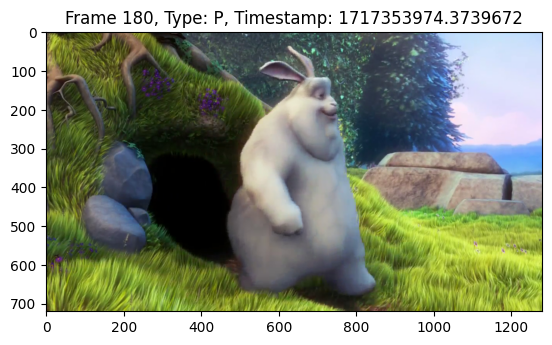

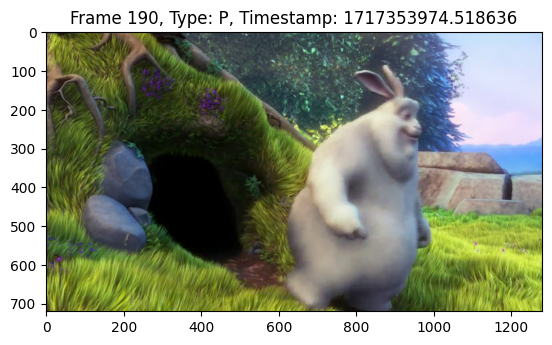

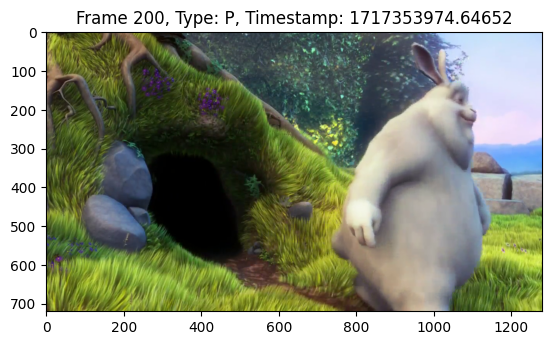

In [ ]:
#@title motion vectors
from mvextractor.videocap import VideoCap
import matplotlib.pyplot as plt
import cv2

# Create an instance of VideoCap class
cap = VideoCap()
cap.open(video_path)

frames_to_extract = [180, 190, 200]
frame_count = 0

frames = []


scale = 0.2  # to make vectors half the length, adjust as needed

while cap.grab():
    if frame_count in frames_to_extract:
        success, frame, motion_vectors, frame_type, timestamp = cap.retrieve()
        if success:
            # Convert frame from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            for i in range(motion_vectors.shape[0]):
                src_x, src_y = motion_vectors[i, 3], motion_vectors[i, 4]
                dst_x, dst_y = motion_vectors[i, 5], motion_vectors[i, 6]
                motion_scale = motion_vectors[i, 9]

                start_point = (src_x, src_y)
                end_point = (dst_x - int((src_x - dst_x) * motion_scale * scale), dst_y - int((src_y - dst_y) * motion_scale * scale))

                # Draw arrow from source to calculated end point with specified color and thickness

            frames.append((frame_rgb, frame_count, frame_type, timestamp))

    frame_count += 1

# Close the VideoCap object
cap.release()

# Plot frames
for frame_rgb, frame_count, frame_type, timestamp in frames:
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_count}, Type: {frame_type}, Timestamp: {timestamp}')
    plt.show()

Above, we can clearly see the motion vectors. Let's take a closer look at how they are calculated

In [ ]:
#@title title

from mvextractor.videocap import VideoCap
import matplotlib.pyplot as plt
import cv2


frames_to_extract = [179, 180,
                     189, 190,
                     199, 200]

def extract_frames(video_path, frames_to_extract, scale=0.2):
    cap = VideoCap()
    cap.open(video_path)

    frame_count = -1
    extracted_frames = []

    while cap.grab():
        frame_count += 1
        if frame_count in frames_to_extract:
            success, frame, motion_vectors, frame_type, timestamp = cap.retrieve()
            if not success:
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            extracted_frames.append(frame_rgb)

    cap.release()

    return extracted_frames


extracted_frames = extract_frames(video_path, frames_to_extract)

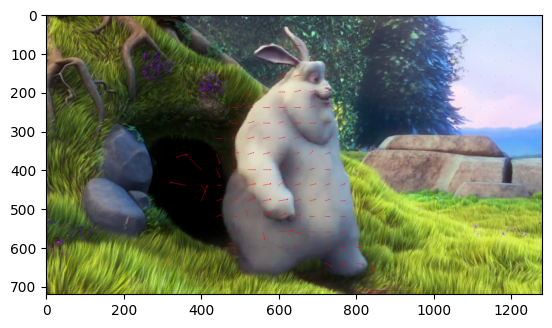

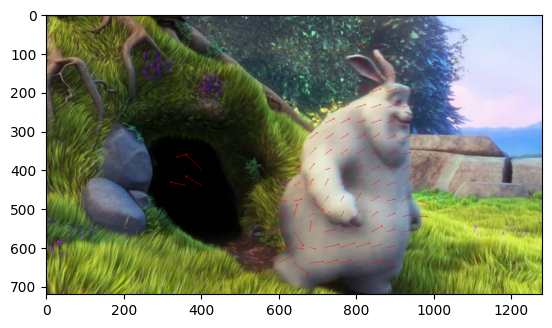

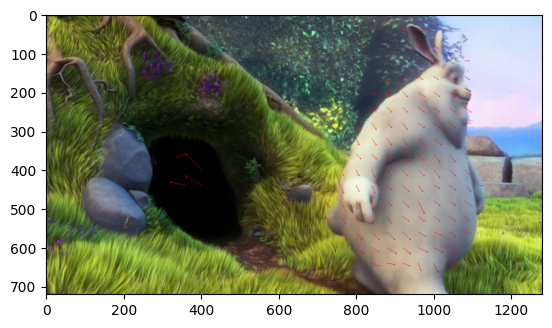

In [ ]:
#@title title

import numpy as np
import cv2

RED = (255, 0, 0)


def mse(a1: np.ndarray, a2: np.ndarray) -> float:
    return np.square(np.subtract(a1, a2)).mean()


def kl(img1: np.ndarray, img2: np.ndarray, block: int, step: int) -> np.ndarray:
    assert img1.shape == img2.shape
    Y, X, ch = img1.shape
    assert X % block == 0, f"{X=}, {block=}"
    assert Y % block == 0, f"{Y=}, {block=}"
    best_flows: dict[tuple[int, int], tuple[int, int]] = {}

    for xb in range(block, X - block, block):
        for yb in range(block, Y - block, block):
            lowest_mse = float("+inf")
            best_vector = 0, 0

            y1, y2 = yb, yb + block
            x1, x2 = xb, xb + block

            for x in range(xb - block, xb + block, step):
                for y in range(yb - block, yb + block, step):
                    y11, y12 = y, y+block
                    x11, x12 = x, x+block
                    err = mse(img1[y1:y2, x1:x2],
                              img2[y11:y12, x11:x12])
                    if err < lowest_mse:
                        lowest_mse = err
                        best_vector = y11, x11
            best_flows[y1, x1] = best_vector
    return best_flows


def draw_kl(img: np.ndarray, best_flows: dict[tuple[int, int], tuple[int, int]]):
    for block, vector in best_flows.items():
        img = cv2.arrowedLine(img, block[::-1], vector[::-1], RED, 1)
    return img

import copy

for i in range(len(extracted_frames) // 2):
    img1, img2 = extracted_frames[2*i:2*i+2]
    img1 = copy.deepcopy(img1)
    img2 = copy.deepcopy(img2)
    BLOCK = 40
    best_flows = kl(img1, img2, BLOCK, BLOCK // 10)
    plt.imshow(draw_kl(img1, best_flows))
    plt.show()